In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from numpy import exp
# TA: Dana Research Center 309

In [2]:
world_size = 20
world =\
"""wwwwwwwwwwwwwwwwwwww
w          bb      w
wbbb w  o       o  w
w    w       e     w
w owwwwwwwwwwwwww  w
wb w  o  b       b w
w  w  w  w     w b w
w bw  w  wbbwwww b w
w     w  w     w b w
w     w  w     w   w
wwwww w  ww    w  ow
w     w   w  w www w
w  wwwww  wbbw   w w
w      w  w  w   w w
wbb    w  w  w     w
w   s  w  o  wwwwbbw
w      b  o        w
www    wwwwww o  o w
w      o           w
wwwwwwwwwwwwwwwwwwww"""

w = world.split('\n')
gridworld_char = []
for i in range(len(w)):
    gridworld_char.append(list(w[i]))

In [3]:
# State Space
S_SIZE = 248
class State:
    def __init__(self, row, col, content):
        # state
        self.row = row
        self.col = col
        self.content = content
        self.index = 0
        #action
        self.action_space = [0,1,2,3] #UDLR
        # next state
        self.next_index = []
        # Q value
        self.Q = [0,0,0,0]  # UDLR
        self.V = 0
        self.H = [0,0,0,0]  # UDLR
        self.policy = 0

In [4]:
# Initialize State Space
S_space = []
for row in range(world_size):
    for col in range(world_size):
        content = gridworld_char[row][col]
        if content != 'w':
            S_space.append(State(row, col, content))
num = len(S_space)


# initialize neighbor states
terminal_index = 0
start_index = 0
i = 0 

for state in S_space:
    # start
    if state.content == 's':
        start_index = S_space.index(state)
    # goal
    if state.content == 'e':
        terminal_index = S_space.index(state)
    # index
    state.index = i
    i = i+1
    # Find neighbor coordinates
    row = state.row
    col = state.col
    coordinates = [[row-1, col],    #up
                   [row+1, col],    #down
                   [row, col-1],    #left
                   [row, col+1]]    #right
    # Loop neighbor coordinates
    for coord in coordinates:
        is_state = False
        next_state = 0
        # Is this coord a state
        for s in S_space:
            if coord[0]==s.row and coord[1]==s.col:
                next_state = s
                is_state = True
        # Yes
        if is_state:
            state.next_index.append(S_space.index(next_state))
        # No
        else:
            state.next_index.append(S_space.index(state))

# Test
# state = S_space[230]
# print(state.action)
# print(state.row, state.col,)
# print(state.next_index)
# print(len(S_space))


In [5]:
# Action Space
A = ['U', 'D', 'L', 'R']

# Reward
def Reward(state, action, next_state):
    reward = -1    
    # rewards
    if next_state.content=='b':
        reward = reward -10
    if next_state.content=='o':
        reward = reward -5
    if next_state.content=='e':
        reward = reward +800
    if state.content == 'e':
        reward = 0
    return reward

# Epsilon Greedy
def Egreedy(state, epsilon):
    num = np.random.uniform(0,1)
    action = 0
    if(num < epsilon):      # random
        action =  np.random.randint(4)
    else:                   # greedy
        action =  np.argmax(state.Q)
    return action

In [6]:
# SARSA
def SARSA(S_space, param):
    prob = param[0]
    gamma = param[1]
    alpha = param[2]
    epsil = param[3]
    beta = param[4]
    max_episode = param[5]
    max_step = param[6]
    accu_reward = []

    for i in range(max_episode):
        sum_reward = 0
        # Initialize
        # s, a
        state = S_space[np.random.randint(248)]
        action = Egreedy(state, epsil)

        # For Each Episode
        for i in range(max_step):
            
            # Stop if goal is reached
            if S_space.index(state) == terminal_index:
                break

            # s', R
            nxt_state = S_space[state.next_index[action]]
            R = Reward(state, action, nxt_state)

            # Q(s, a)
            Q = state.Q[action]

            # Q(s', a')
            nxt_action = Egreedy(nxt_state, epsil)
            Q_next = nxt_state.Q[nxt_action]

            # Update Q(s,a)
            state.Q[action] = Q + alpha* (R + gamma*Q_next - Q)

            # s->s', a->a'
            state = nxt_state
            action = nxt_action

            # Accumulated Reward
            sum_reward += R

        accu_reward.append(sum_reward)
        
        # Update Policy
        for s in S_space:
            s.policy = np.argmax(s.Q)
            
    return accu_reward


In [7]:
# Q-Learning
def QLearning(S_space, param):
    prob = param[0]
    gamma = param[1]
    alpha = param[2]
    epsil = param[3]
    beta = param[4]
    max_episode = param[5]
    max_step = param[6]
    accu_reward = []

    for i in range(max_episode):
        sum_reward = 0
        # Initialize s
        state = S_space[np.random.randint(248)]

        # For Each Episode
        for i in range(max_step):
            # Stop if goal is reached
            if S_space.index(state) == terminal_index:
                break
            # choose a
            action = Egreedy(state, epsil)
            # take action a, observe r, s'
            nxt_state = S_space[state.next_index[action]]
            R = Reward(state, action, nxt_state)
            # Q(s, a)
            Q = state.Q[action]
            # maxQ(s',a')
            Q_next = max(nxt_state.Q)
            # Update Q(s, a)
            state.Q[action] = Q + alpha* (R + gamma*Q_next - Q)
            # s->s'
            state = nxt_state
            # Accumulated Reward
            sum_reward += R
            
        accu_reward.append(sum_reward)

        # Update Policy
        for s in S_space:
            s.policy = np.argmax(s.Q)

    return accu_reward
        

In [8]:
# Action Selection
def PSelect(state):
    sum = 0
    prob = []
    for a in range(len(state.action_space)):
        sum += exp(state.H[a])
    for a in range(len(state.action_space)):
        prob.append(exp(state.H[a]) / sum)
    return prob

# Actor-Critic
def ActorCritic(S_space, param):
    # Parameters
    p = param[0]
    gamma = param[1]
    alpha = param[2]
    epsil = param[3]
    beta = param[4]
    max_episode = param[5]
    max_step = param[6]
    accu_reward = []

    #Episode
    for i in range(max_episode):
        sum_reward = 0
        # Initialize random S
        state = S_space[np.random.randint(248)]
        # For each episode
        for i in range(max_step):
            # Stop if goal is reached
            if S_space.index(state) == terminal_index:
                break
            # select A
            prob = PSelect(state)
            action = np.random.choice(state.action_space, p=prob)
            # Take action A, observe S', R'
            nxt_state = S_space[state.next_index[action]]
            R = Reward(state, action, nxt_state)
            sum_reward += R
            # Update V, H
            delta = R + gamma * nxt_state.V - state.V
            state.V = state.V + alpha * delta
            state.H[action] = state.H[action] + beta * delta * (1 - prob[action])
            # S'->S
            state = nxt_state

        accu_reward.append(sum_reward)
    # Update Policy
    for s in S_space:
        s.policy = np.argmax(PSelect(s))

    return accu_reward

In [9]:
# Path Find
def get_path(S_space):
    # get start end index
    for s in S_space:
        if s.content == 's':
            start_index = S_space.index(s)
        if s.content == 'e':
            terminal_index = S_space.index(s)
    path = []

    # Loop from start to end
    curr_state = S_space[start_index]
    count = 0
    while curr_state != S_space[terminal_index]:
        path.append(curr_state)
        action = curr_state.policy
        next_state_index = curr_state.next_index[action]
        curr_state = S_space[next_state_index]
        count = count+1
        if count>len(S_space):
            return path
    return path

In [10]:
# PLOT FUNCTION
def plot_map(gridworld_char, S_space, plot_type):
    # Wall map
    gridworld_int = np.zeros((world_size,world_size))
    for i in range(world_size):
        for j in range(world_size):
            if gridworld_char[i][j] == 'w':
                gridworld_int[i][j] = np.NAN
            else:
                gridworld_int[i][j] = 0

    # Annotate numbers
    ANNOT = None

    # Plot Heatmap
    plt.subplots(figsize=(10,7.5))  
    heatmap = sns.heatmap(gridworld_int, fmt=".0f", annot=ANNOT, linewidths=0.25, linecolor='black',
                        cbar= False, cmap= 'rocket_r')
    heatmap.set_facecolor('black')

    # state blocks
    for x in range(world_size):
        for y in range(world_size):
            if gridworld_char[x][y] == 'o': # Oil
                rect = Rectangle((y, x), 1, 1, fill=True, color='red', alpha = 0.8)
                heatmap.add_patch(rect)
            if gridworld_char[x][y] == 'b': # Bump
                rect = Rectangle((y, x), 1, 1, fill=True, color='red', alpha = 0.25)
                heatmap.add_patch(rect)
            if gridworld_char[x][y] == 's': # Start
                rect = Rectangle((y, x), 1, 1, fill=True, color='blue', alpha = 0.8)
                heatmap.add_patch(rect)
            if gridworld_char[x][y] == 'e': # End
                rect = Rectangle((y, x), 1, 1, fill=True, color='green', alpha = 0.8)
                heatmap.add_patch(rect)

    # Arrows
    if plot_type != "V_map":
        if plot_type == 'arrow':
            arrow_space = S_space
            arrow_len = 0.3
        elif plot_type == 'path':
            arrow_space = get_path(S_space)
            arrow_len = 0.8
        for state in arrow_space:
            if state.content == 'e':
                continue
            if state.Q[0]+state.Q[1]+state.Q[2]+state.Q[3] == 0:
                continue
            r = state.row # x_coordinate
            c = state.col # y_coordinate
            if state.policy == 0:
                plt.arrow(c + 0.5, r + 0.5, 0, -arrow_len, width=0.04, color='black')  # Up
            if state.policy == 1:
                plt.arrow(c + 0.5, r + 0.5, 0, arrow_len, width=0.04, color='black')  # Down
            if state.policy == 2:
                plt.arrow(c + 0.5, r + 0.5, -arrow_len, 0, width=0.04, color='black')  # Left
            if state.policy == 3:
                plt.arrow(c + 0.5, r + 0.5, arrow_len, 0, width=0.04, color='black')   # Right

    plt.show()

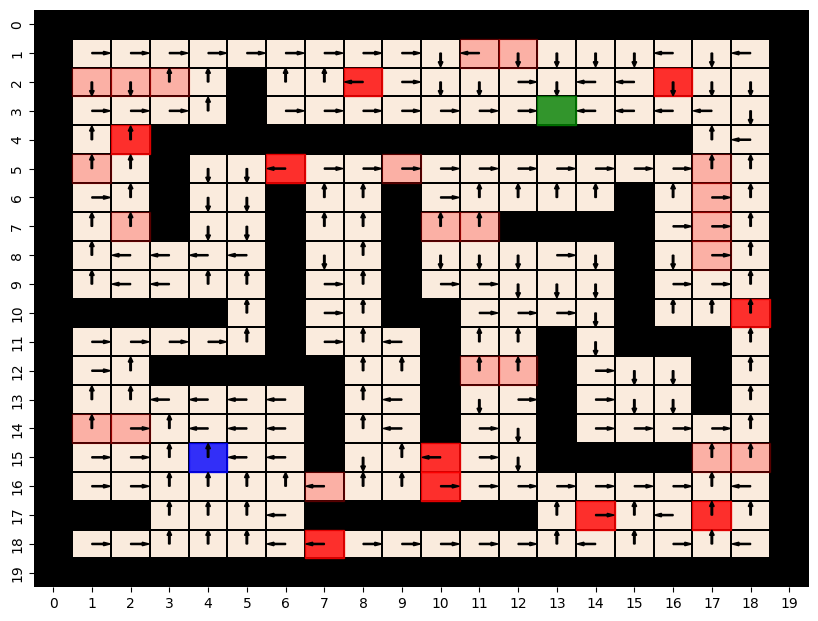

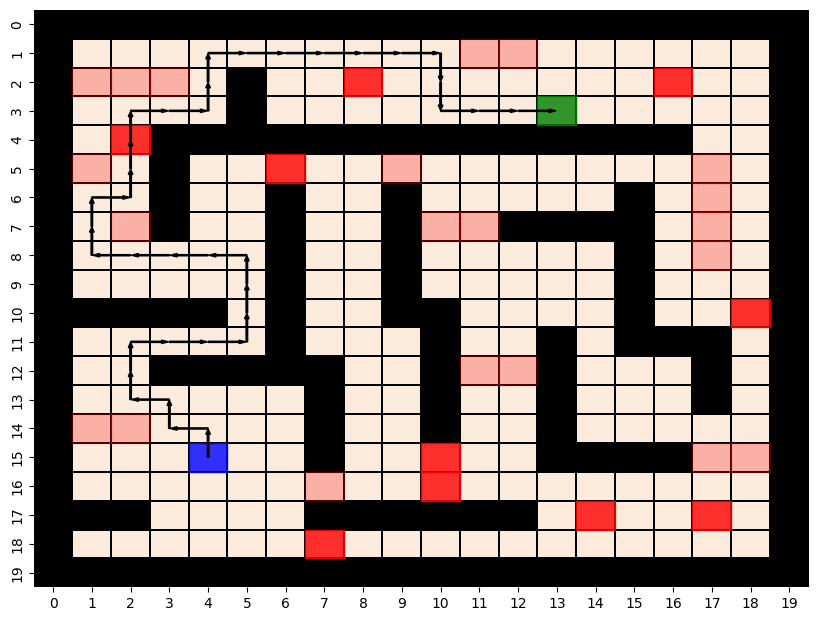

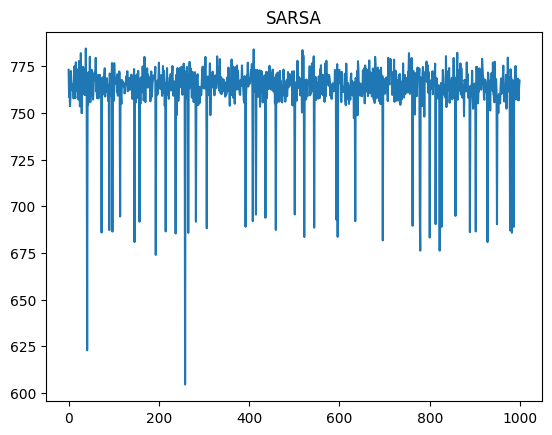

In [11]:
# Parameters
p = 0.02
gamma = 0.95
alpha = 0.3
epsilon = 0.1
beta = 0.3
max_episode = 1000
max_step = 1000
param = [p, gamma, alpha, epsilon, beta, max_step, max_episode]
max_run = 10

# RUN
def run(algorithm):
    sum = np.zeros(max_episode)
    for i in range(max_run):
        states = S_space.copy()
        if algorithm == 0:      # SARSA
            accu_reward = SARSA(states, param)
        elif algorithm == 1:    # Q_Learning
            accu_reward = QLearning(states, param) 
        elif algorithm == 2:
            accu_reward = ActorCritic(S_space, param)
        sum += accu_reward
    return sum

# SARSA
S_sarsa = S_space.copy()
accu_reward = SARSA(S_sarsa, param)
plot_map(gridworld_char, S_sarsa, 'arrow')
plot_map(gridworld_char, S_sarsa, 'path')
# plt.plot(np.arange(len(accu_reward)),accu_reward)
plt.show()


# Accu Reward
sum_sarsa = run(0)
plt.plot(np.arange(len(sum_sarsa)),sum_sarsa/max_run)
plt.title("SARSA")
plt.show()

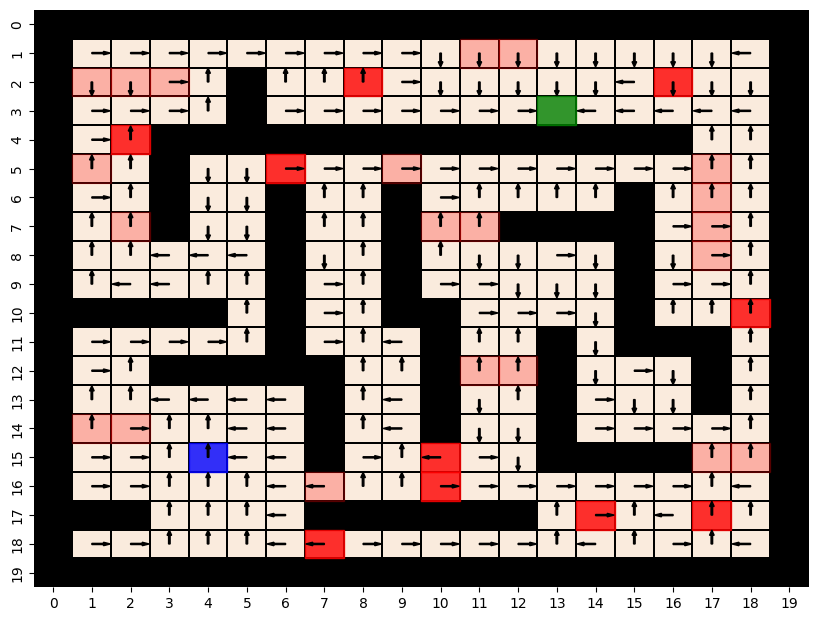

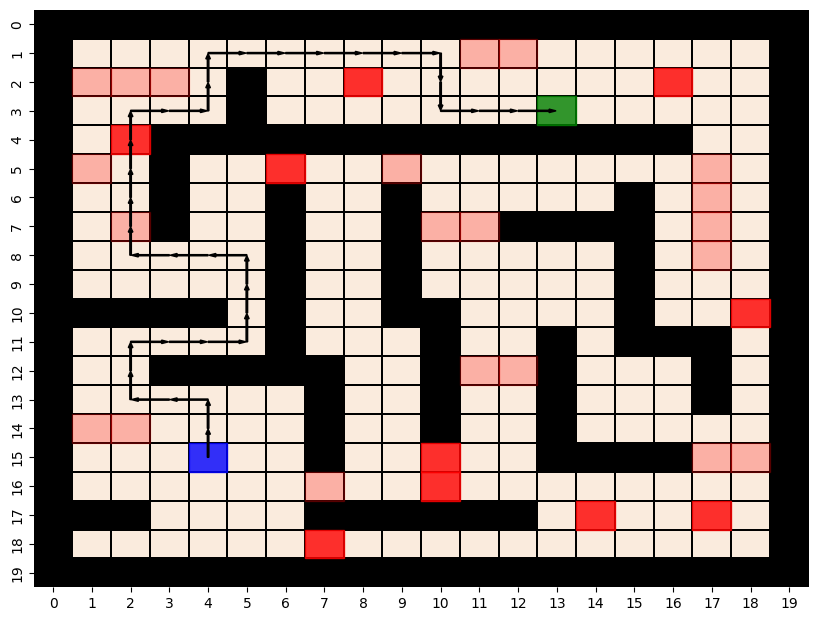

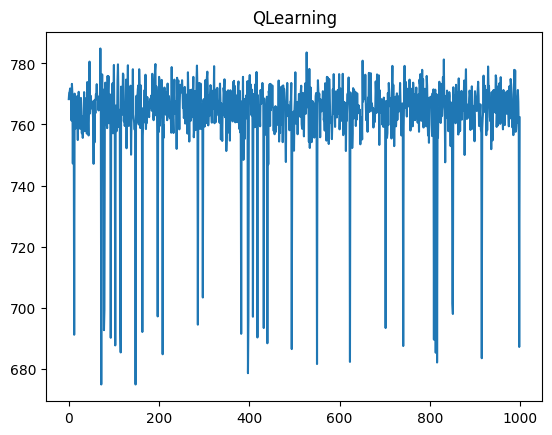

In [12]:
# Q_learning
S_QLearning = S_space.copy()
accu_reward = QLearning(S_QLearning, param)
plot_map(gridworld_char, S_QLearning, 'arrow')
plot_map(gridworld_char, S_QLearning, 'path')
# plt.plot(np.arange(len(accu_reward)),accu_reward)
plt.show()

# Accu Reward
sum_q = run(1)
plt.plot(np.arange(len(sum_q)),sum_q/max_run)
plt.title("QLearning")
plt.show()

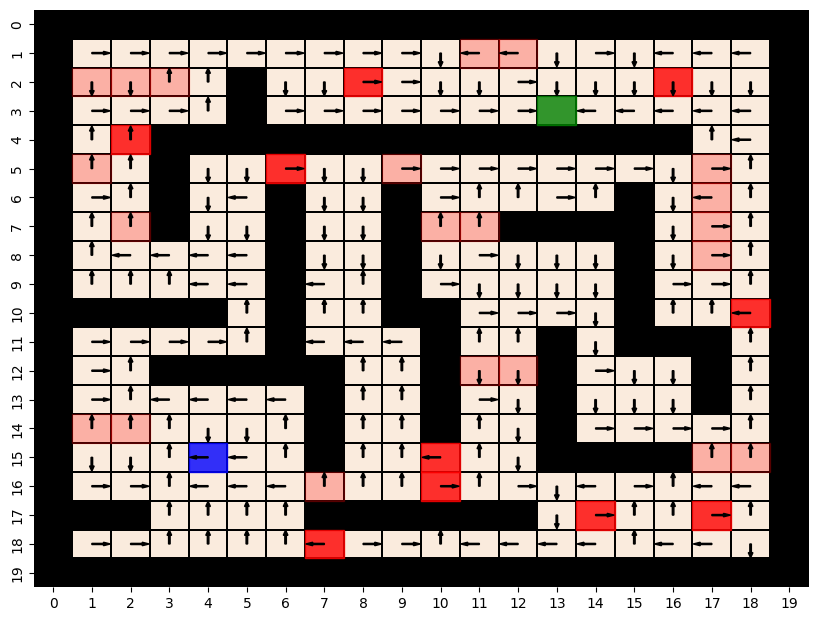

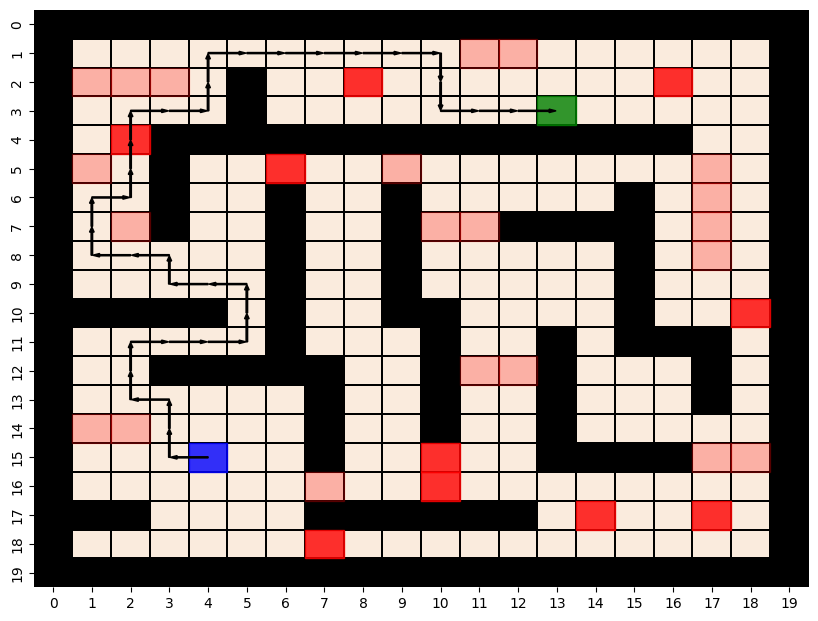

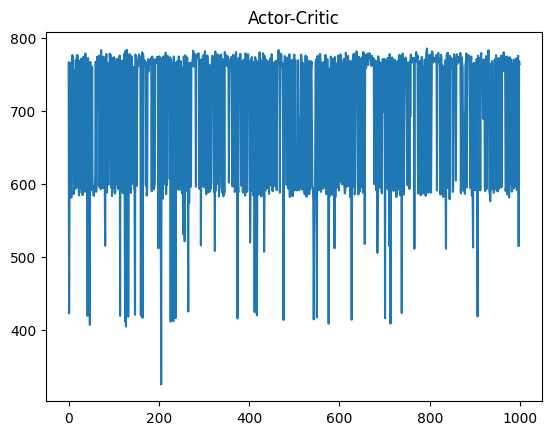

In [13]:
# Actor-Critic
S_Acritic = S_space.copy()
accu_reward = ActorCritic(S_Acritic, param)
plot_map(gridworld_char, S_Acritic, 'arrow')
plot_map(gridworld_char, S_Acritic, 'path')
plt.show()

# Accu Reward
sum_a = run(2)
plt.plot(np.arange(len(sum_a)),sum_a/max_run)
plt.title("Actor-Critic")
plt.show()

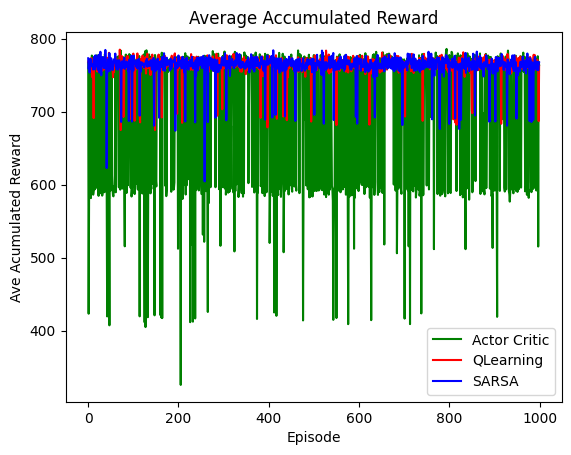

In [16]:
plt.plot(np.arange(len(sum_a)),sum_a/max_run, 'g-', label="Actor Critic")
plt.plot(np.arange(len(sum_q)),sum_q/max_run, 'r-', label="QLearning")
plt.plot(np.arange(len(sum_sarsa)),sum_sarsa/max_run, 'b-', label="SARSA")
plt.legend()
plt.title("Average Accumulated Reward")
plt.xlabel("Episode")
plt.ylabel("Ave Acumulated Reward")
plt.show()